In [1]:
from shape2series.experiments import StoreMorphologiShapeSeries
import toml

In [2]:
config = toml.load(open('../../experiments/morphologi_1.toml'))

In [18]:
exp = StoreMorphologiShapeSeries(config=config, working_dir='../../../', log_level='INFO')

2020-05-17 21:14:11.316 | INFO     | shape2series.experiments:__init__:65 - Detected 1 total runs.


In [19]:
exp.run()

2020-05-17 21:14:12.306 | INFO     | shape2series.experiments:run:70 - Running Experiment Suite: Morphologi-Shapes
2020-05-17 21:14:12.307 | INFO     | shape2series.experiments:run:83 - Begining experiment 1 of 1
2020-05-17 21:20:05.864 | INFO     | shape2series.experiments:run_pipeline:168 - Saved all images and objects to C:\Users\Chris.Musselle\malvern\projects\secondary\shape-to-series\results\Morphologi-Shapes\images.hdf5
2020-05-17 21:20:05.865 | INFO     | shape2series.experiments:run_pipeline:169 - 0 images failed processing.


In [20]:
list(exp.results_dir.iterdir())

[WindowsPath('C:/Users/Chris.Musselle/malvern/projects/secondary/shape-to-series/results/Morphologi-Shapes/images.hdf5')]

# Investigate Distribution of Contour Area and Perimeter

In [3]:
import h5py

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
# sb.set_context('notebook')

In [12]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [13]:
plt.rc('figure', figsize=(12,6))

In [14]:
f = h5py.File('../../../results/Morphologi-Shapes/images.hdf5')

In [15]:
def fetch_contour_properties(key):
    values = []
    for image in f['images'].keys():
        contour = f['contours'][f'{image}-0']
        values.append(contour.attrs[key])
        
    return values

In [9]:
image_areas = fetch_contour_properties(key='area')
image_perimeters = fetch_contour_properties(key='perimeter')
image_eccentricity = fetch_contour_properties(key='eccentricity')
image_solidity = fetch_contour_properties(key='solidity')

In [16]:
sb.distplot(image_areas, bins=1000, kde=False)

In [17]:
sb.distplot(image_perimeters, bins=200, kde=False)

Area: $A = \pi r^2$

Circumference: $C = 2 \pi r$




$r = \sqrt{A / \pi}$ 

$C = 2 \pi \sqrt{A / \pi} $

$C^2 = 4 \pi A $

$C = 2 \sqrt{\pi A} $

In [18]:
xs = np.linspace(0, max(image_areas), 5000)
ys = 2 * np.sqrt(np.pi * xs)

In [19]:
axes = sb.jointplot(
    x=image_areas, y=image_perimeters,
    joint_kws={'alpha': 0.1}, 
    marginal_kws={'bins': 200},
)
axes.ax_joint.plot(xs, ys, 'C1')

# Making an interactive plot

C:\Users\Chris.Musselle\AppData\Local\Continuum\anaconda3\envs\shape2ts\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))




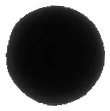

In [20]:
from PIL import Image
import io
import base64
import numpy
from skimage.util import img_as_uint, img_as_ubyte
from skimage.io import imsave

encoded_data = []
image_filenames = []
for image in f['images'].keys():
    data = f['images'][image]    
    rawBytes = io.BytesIO()    
    im = Image.fromarray(img_as_ubyte(np.array(data)))
    im.save(rawBytes, "PNG")
    rawBytes.seek(0) 
    encoded_image = base64.b64encode(rawBytes.read()).decode()
    encoded_data.append(f'data:image/png;base64,{encoded_image}')
    image_filenames.append(image)
        
print(encoded_data[0])


## Area vs Perimeter

In [21]:
from bokeh.plotting import ColumnDataSource, figure, output_file, show

output_file("toolbar.html")

source = ColumnDataSource(data=dict(
    x=image_areas,
    y=image_perimeters,
#     desc=['A', 'b', 'C', 'd', 'E'],
    imgs=encoded_data,
    filenames=image_filenames
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="100" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@filenames</span>
            <span style="font-size: 15px; color: #966;">[$index]</span>
        </div>
    </div>
"""

p = figure(plot_width=1500, plot_height=700, tooltips=TOOLTIPS,
           title="Mouse over the dots")

p.circle('x', 'y', size=10, source=source, fill_alpha=0.3, line_alpha=0.3)

show(p)


## Ecsentricity vs perimeter

In [42]:
from bokeh.plotting import ColumnDataSource, figure, output_file, show

output_file("toolbar.html")

source = ColumnDataSource(data=dict(
    x=image_eccentricity,
    y=image_areas,
#     desc=['A', 'b', 'C', 'd', 'E'],
    imgs=encoded_data,
    filenames=image_filenames
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="100" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@filenames</span>
            <span style="font-size: 15px; color: #966;">[$index]</span>
        </div>
    </div>
"""

p = figure(plot_width=1500, plot_height=700, tooltips=TOOLTIPS,
           title="Mouse over the dots")

p.circle('x', 'y', size=10, source=source, fill_alpha=0.3, line_alpha=0.3)

show(p)


In [57]:
show(p)

# Filter to a Data Subset

In [49]:
min_area = 500
max_area = 80_000


images = []

for image in f['images'].keys():
    contour = f['contours'][f'{image}-0']

    value = contour.attrs['area']
    if value < min_area or value > max_area:
        continue
    value = contour.attrs['eccentricity']
    if value < 0.1:
        continue
            
    images.append(contour)

In [50]:
len(images)

7400

In [45]:
x = 10


In [48]:
15 < x <= 20

False